In [1]:
# load libraries and set plot parameters
import os
import numpy as np
import pandas as pd
import numpy as np
import scipy.spatial as sp
import scipy.stats as st
from pathlib import Path
import logging
import datetime

logger = logging.getLogger()

def setup_file_logger(log_file):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)

def log(message):
    #outputs to Jupyter console
    print('{} {}'.format(datetime.datetime.now(), message))
    #outputs to file
    logger.info(message)

setup_file_logger('out.log')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)
sns.set_style('ticks')
sns.axes_style({'spines.right': False,
                'axes.spines.top': False})
sns.set_palette(sns.cubehelix_palette(4, start=.5, rot=-.75, reverse=True, dark=0.5))

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16

# figures:
# Where to save the figures
PROJECT_ROOT_DIR = "../"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")

if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

%load_ext autoreload
%autoreload 2

In [2]:
from tsp.tsp import TravelingSalesPersonProblem
import tsp.tsp_heuristic as th

In [3]:
def build_plot(heuristic_result):
    start = heuristic_result.get_starting_node_for_plotting()
    x, y = np.array(heuristic_result.get_cycle_for_plotting()).T
    plt.rcParams['figure.figsize'] = (14, 9)
    plt.plot(x, y)
    plt.plot(start[0], start[1], "ro")
    plt.title("Distance travelled: {0:.1f}".format(
        heuristic_result.loss()))
    plt.axis('off')
    plt.show()

# Traveling Salesman Problem

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#Data-structures" data-toc-modified-id="Data-structures-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data structures</a></span></li><li><span><a href="#Construction-heuristics" data-toc-modified-id="Construction-heuristics-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Construction heuristics</a></span><ul class="toc-item"><li><span><a href="#Best-Insertion" data-toc-modified-id="Best-Insertion-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Best Insertion</a></span></li><li><span><a href="#Best-Best-Insertion" data-toc-modified-id="Best-Best-Insertion-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Best-Best Insertion</a></span></li><li><span><a href="#Shortest-Edge" data-toc-modified-id="Shortest-Edge-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Shortest Edge</a></span></li></ul></li><li><span><a href="#Improvement-heuristics" data-toc-modified-id="Improvement-heuristics-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Improvement heuristics</a></span><ul class="toc-item"><li><span><a href="#Greedy-Local-Search" data-toc-modified-id="Greedy-Local-Search-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Greedy Local Search</a></span></li><li><span><a href="#Simulated-Annealing" data-toc-modified-id="Simulated-Annealing-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Simulated Annealing</a></span></li></ul></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Summary-Table" data-toc-modified-id="Summary-Table-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Summary Table</a></span></li><li><span><a href="#Best-Solutions" data-toc-modified-id="Best-Solutions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Best Solutions</a></span></li><li><span><a href="#Pairwise-Comparison" data-toc-modified-id="Pairwise-Comparison-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Pairwise Comparison</a></span><ul class="toc-item"><li><span><a href="#Construction-Heuristics" data-toc-modified-id="Construction-Heuristics-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Construction Heuristics</a></span></li><li><span><a href="#Improvement-Heuristics" data-toc-modified-id="Improvement-Heuristics-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Improvement Heuristics</a></span></li></ul></li><li><span><a href="#Performance-Plots" data-toc-modified-id="Performance-Plots-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Performance Plots</a></span></li></ul></li></ul></div>

## Introduction

The traveling salesman problem is an optimisation problem for which to date no analytical solution has been found. It describes a network of nodes that have to be connected in a tour so that the path connecting all nodes is as short as possible. Each node can only be visited once and thus has exactly two connecting edges.

There are two main families of heuristics for solving the problem. The construction heuristics start with one or a few nodes drawn at random and build the tour from there. The algorithm stops when all nodes are connected in the tour. The family of improvement heuristics start with a randomly chosen tour and then look for possible improvements using several different strategies. The algorithm stops after a certain number of executions.

In the scope of this project, the following heuristics will be showcased:

* Construction heuristics
    * Best insertion
    * Best-best insertion
    * Shortest Edge
* Improvement heuristics
    * Greedy local search with the moves:
        * Swaping
        * Translation
        * Inversion
        * Mixed move
    * Simulated Annealing with the criteria
        * Metropolis
        * Heat bath

## Implementation

### Data structures

Three classes represent the network on which heuristics operate. These are:

* Node: A vertex in the network with x- and y-coordinates and a number
* Edge: A line connecting two nodes with a length (*cost*/*distance*)
* TravelingSalesPersonProblem: Has a list of all nodes in the network, holds the distance matrix describing the distance between any two nodes in the network and has a distance metric registered used to compute the distance matrix.

In [4]:
nodes = pd.read_csv("TSP_411.txt", sep='\s+', names=['node', 'x', 'y'])

The network consists of {{len(nodes.index)}} nodes. The nodes are read in from a csv file. The three columns {{list(nodes.columns.values)}} in the file represent the node number and the coordinates of a given node. The unconnected nodes are shown in Figure .

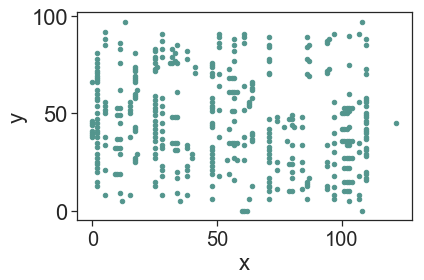

In [5]:
nodes.plot(kind='scatter', x='x', y='y')
save_fig("network_nodes")

In [6]:
tsp = TravelingSalesPersonProblem(nodes)

###  Construction heuristics

#### Best Insertion

The best insertion heuristic starts with 3 randomly chosen nodes. It then randomly selects the next node not included in the tour and finds the pair of nodes between which insertion results in the smallest increase in tour length.

This strategy can be seen as a global optimization.

#### Best-Best Insertion

#### Shortest Edge

The shortest edge works on a list of all possible $n(n-1)$ edges between the nodes in the network. The edges are first sorted by length. Subsequently, the shortest edge is selected as the starting point. From there, the sorted list is searched for the next node meeting the two constraints:

1. Inserted edge does not produce a look that is shorter than the one connecting all nodes
2. The two nodes at the endpoints of the edge do not have more than 2 connected edges after insertion

The algorithm is repeated until the number of edges is equal to the number of edges connecting all nodes in the network.

### Improvement heuristics

The family of improvement heuristics starts with a randomly constructed tour and seeks to improve the loss by performing various operations. The stopping criterion here is a fixed number of improvement operations.

#### Greedy Local Search

Starting with the random tour, randomly selected nodes are subjected to one of several possible moves. The loss with the move applied is compared to the previous loss and if smaller, the new tour is accepted.

##### Translate

##### Swap

##### Invert

##### Mixed moves

#### Simulated Annealing

This heuristic mimics the physical process of annealing metals. At a higher temperature, locally modified cycles have a higher probability of being accepted, so we deliberately accept solutions that increase loss, albeit with a relatively small probability.
The temperature is then gradually decreased, raising the bar for accepting new cycles. When the low temperature is reached, the algorithm stops.

There are two conditions for accepting new cycles:

* Metropolis: This condition accepts all cycles with an improved loss and those with a larger loss at probability [INSERT FORMULA]
* Heatbath: The heatbath condition does not automatically accept cycles with a lower loss.

## Results

In [7]:
import pickle

runs_file = Path('./runs.pkl')
if runs_file.is_file():
    with open(runs_file, 'rb') as input:
        runs = pickle.load(input)
else:
    n_runs = 30
    runs = {
        'BestInsertion': [],
        'BestBestInsertion': [],
        'ShortestEdge': [],
        'GreedyLocalSearchSwap': [],
        'GreedyLocalSearchTranslate': [],
        'GreedyLocalSearchInvert': [],
        'GreedyLocalSearchMixed': [],
        'SimulatedAnnealingMetropolis': [],
        'SimulatedAnnealingHeatBath': []
    }

    for i in range(n_runs):
        heuristics = [
            th.BestInsertion(tsp),
            th.BestBestInsertion(tsp),
            th.ShortestEdge(tsp),
            th.GreedyLocalSearchSwap(tsp),
            th.GreedyLocalSearchTranslate(tsp),
            th.GreedyLocalSearchInvert(tsp),
            th.GreedyLocalSearchMixed(tsp),
            th.SimulatedAnnealingMetropolis(tsp),
            th.SimulatedAnnealingHeatBath(tsp)
        ]
        for h in heuristics:
            h.calculate_cycle()
            runs[h.__class__.__name__].append([h.loss(), h.get_cycle()])
            log("Iteration {}: {} done".format(i+1, h.__class__.__name__))
    with open('./runs.pkl', 'wb') as output:
        pickle.dump(runs, output)

In [8]:
losses = {}
for (key, value) in runs.items():
    l = []
    for i in range(len(value)):
        l.append(value[i][0])
    losses[key] = l
losses_pd = pd.DataFrame.from_dict(losses)

### Summary Table

In [9]:
stats = losses_pd.describe().drop(['count','25%','50%','75%'])

In [10]:
def calc_ci(x, conf_int=0.95):
    return st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x))

In [11]:
ci = pd.DataFrame(losses_pd.apply(calc_ci),columns=["CI"]).T

In [12]:
stats = pd.concat([stats,ci])

In [13]:
stats

,BestInsertion,BestBestInsertion,ShortestEdge,GreedyLocalSearchSwap,GreedyLocalSearchTranslate,GreedyLocalSearchInvert,GreedyLocalSearchMixed,SimulatedAnnealingMetropolis,SimulatedAnnealingHeatBath
mean,1540.74,1942.83,1696.93,3889.64,2276.4,1701.77,1547.03,3499.62,3682.12
std,32.644,16.2637,4.62521e-13,224.282,112.515,73.7217,30.9267,145.043,90.183
min,1483.79,1924.62,1696.93,3492.42,2049.85,1599.52,1482.99,3220.61,3519.86
max,1638.83,1972.55,1696.93,4310.23,2584.57,1922.46,1622.03,3740.94,3873.35
CI,"(1528.5550595288043, 1552.9339735970368)","(1936.7548469876633, 1948.9007764824569)","(1696.933895839845, 1696.9338958398455)","(3805.8892673690816, 3973.3857291584973)","(2234.390164386192, 2318.4175719911764)","(1674.2417748322098, 1729.2980254700108)","(1535.4815013104017, 1558.57793375846)","(3445.458640764157, 3553.778537132564)","(3648.4422345065373, 3715.7919963359122)"


### Best Solutions

In [14]:
hr = th.TspHeuristic(tsp)

In [15]:
import pandas as pd

In [16]:
runs_pd = pd.DataFrame.from_dict(runs)

In [17]:
min_results = runs_pd.min()

In [18]:
def plot_resulting_cycle(heuristic, results):
    x, y = np.array(hr.get_cycle_for_plotting(results[1])).T
    plt.rcParams['figure.figsize'] = (14, 9)
    plt.plot(x, y)
    plt.title("Heuristic: {algo} has shortest cycle {loss:.1f}".format(algo=heuristic, loss=results[0]))
    plt.axis('off')
    save_fig("min_"+heuristic)
    plt.show()

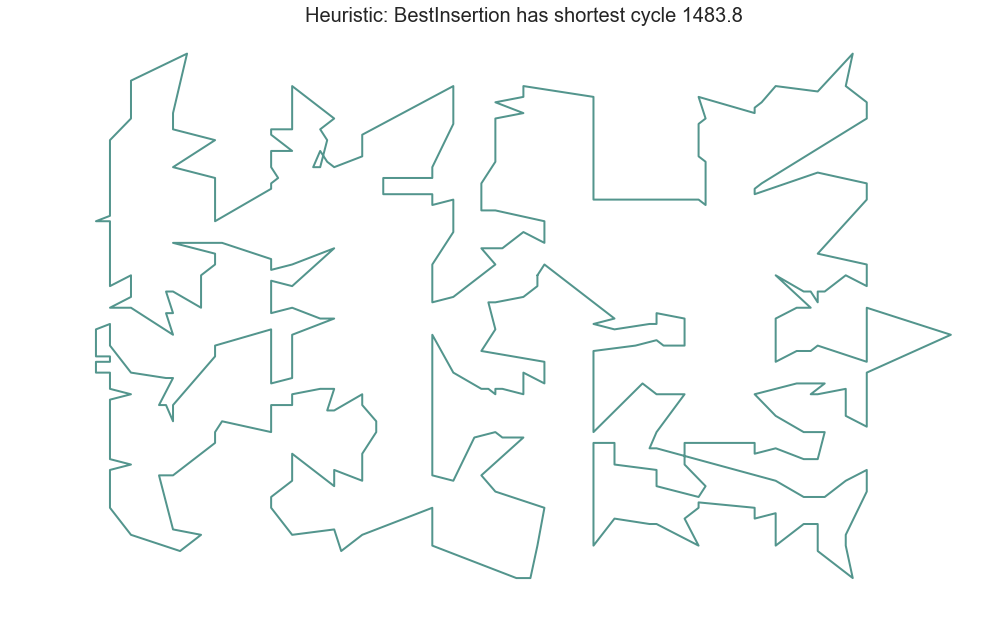

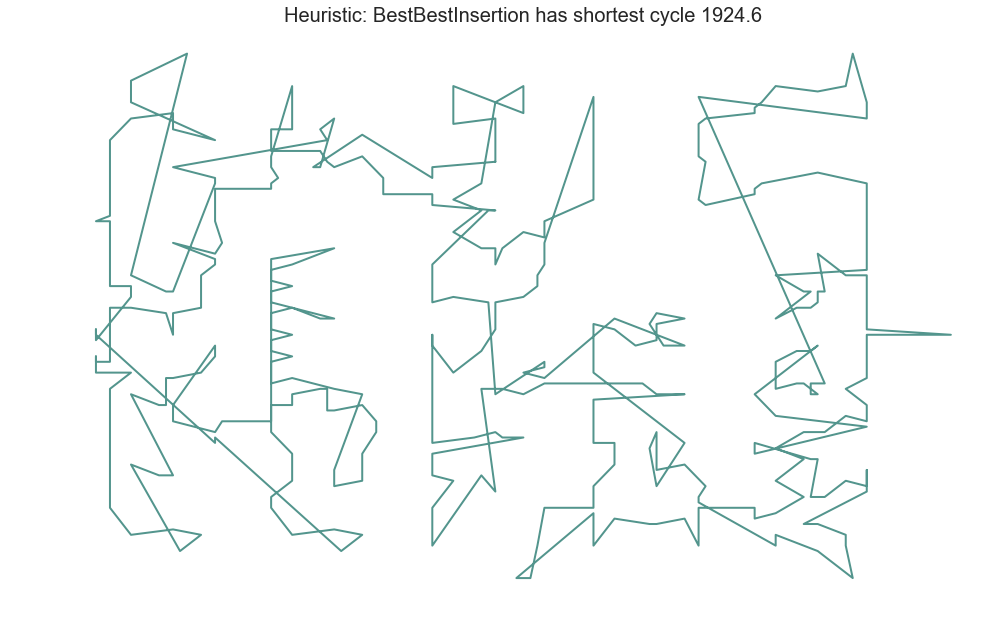

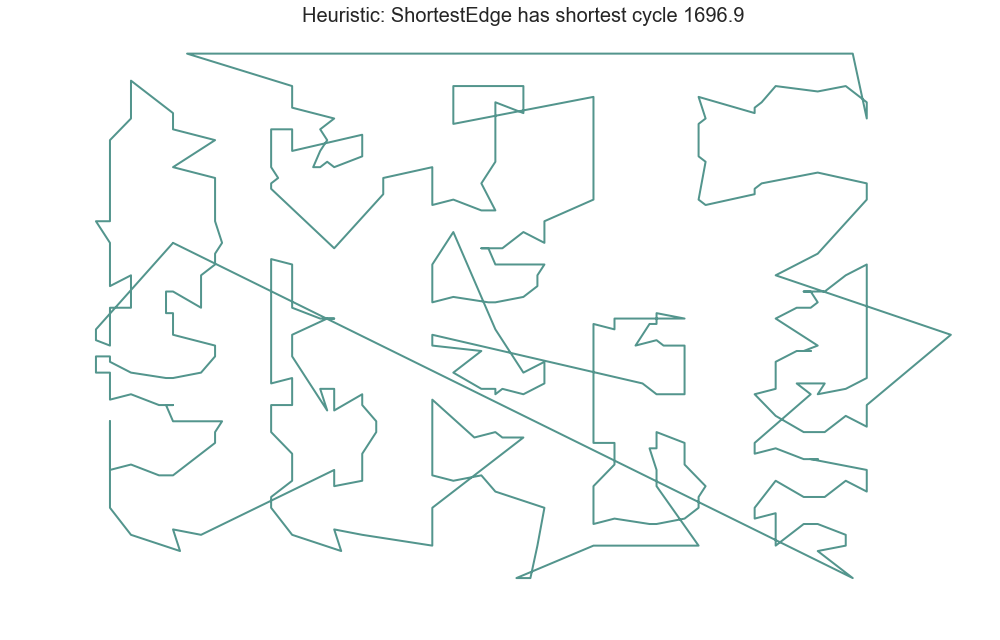

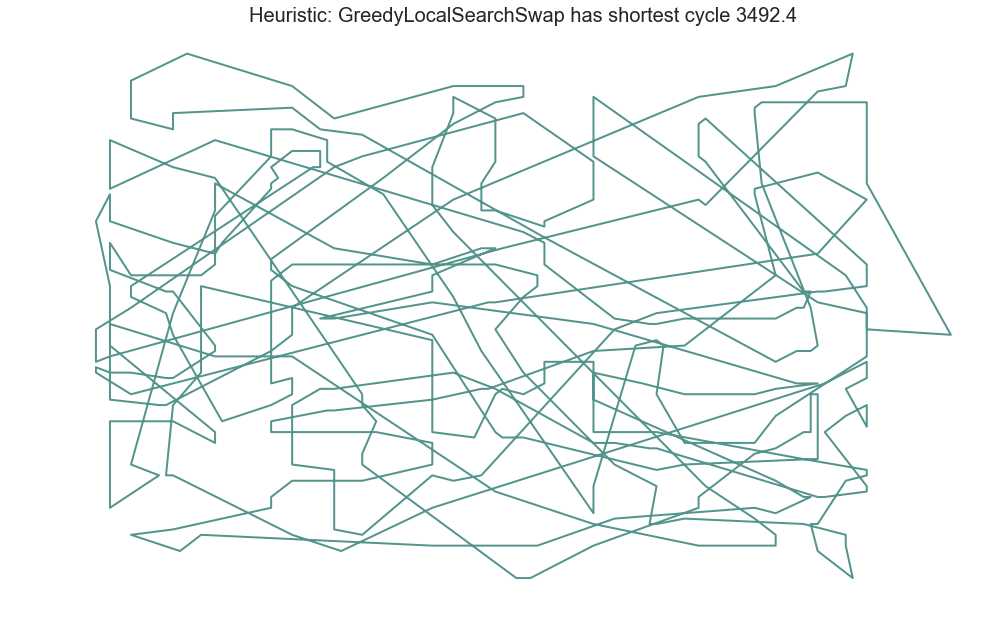

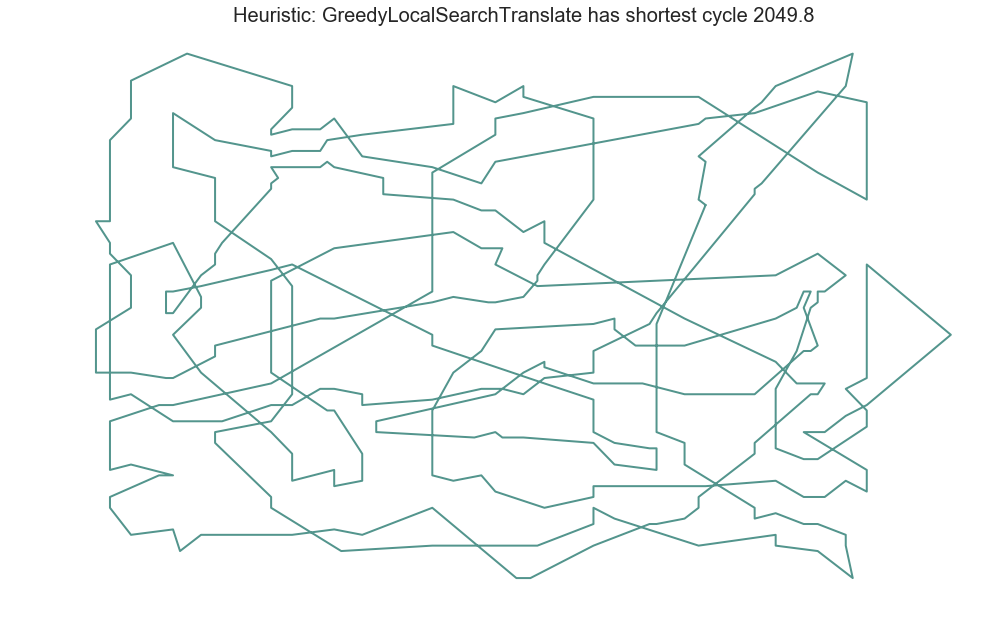

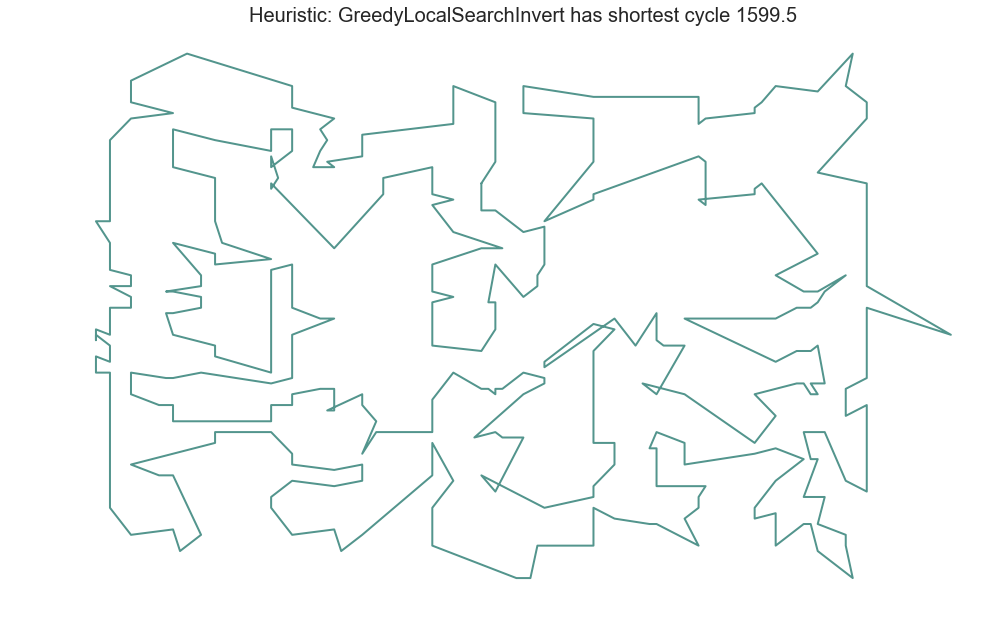

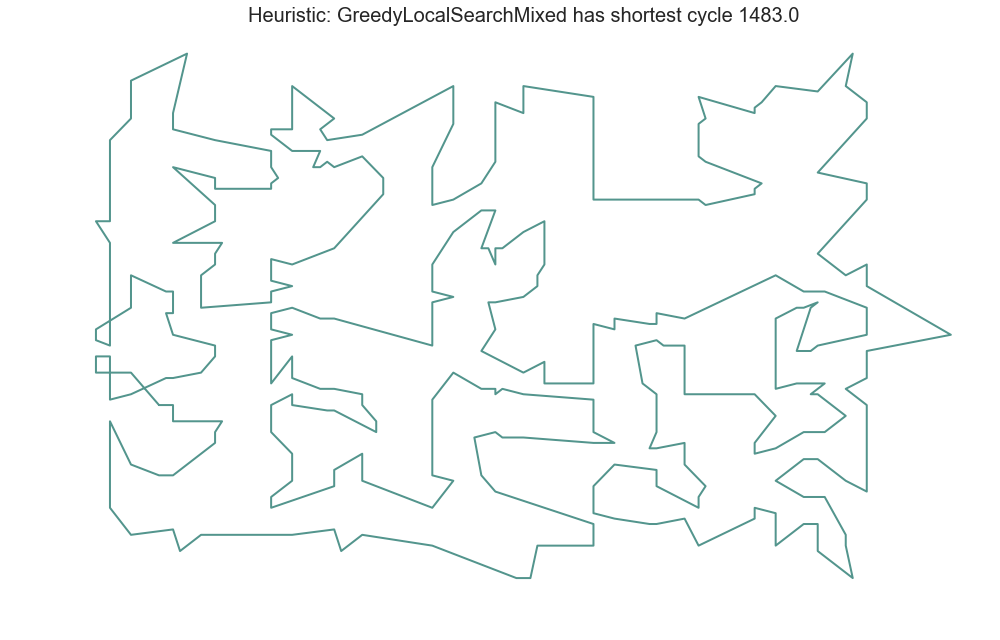

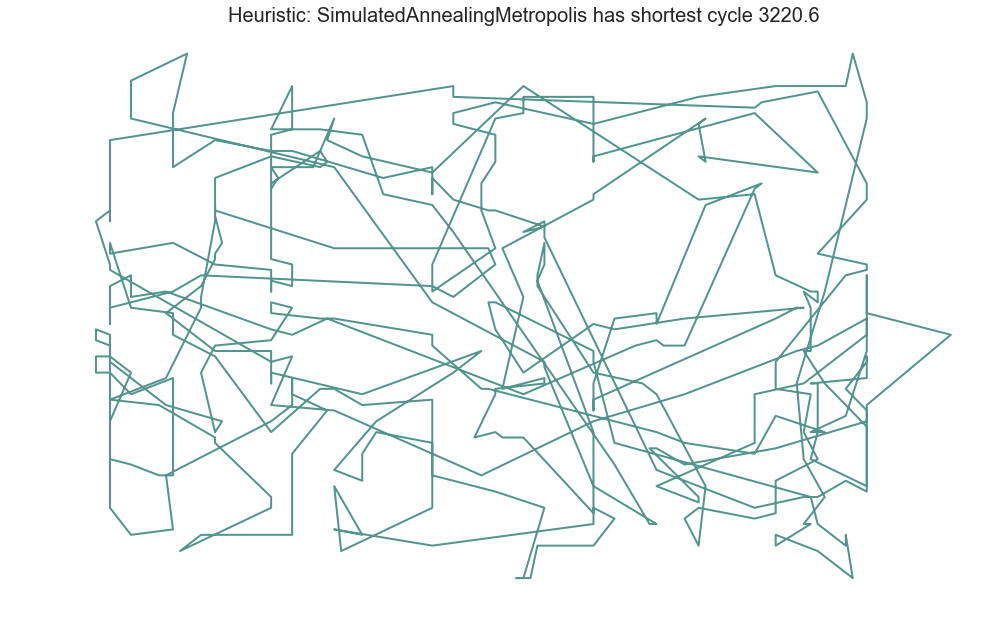

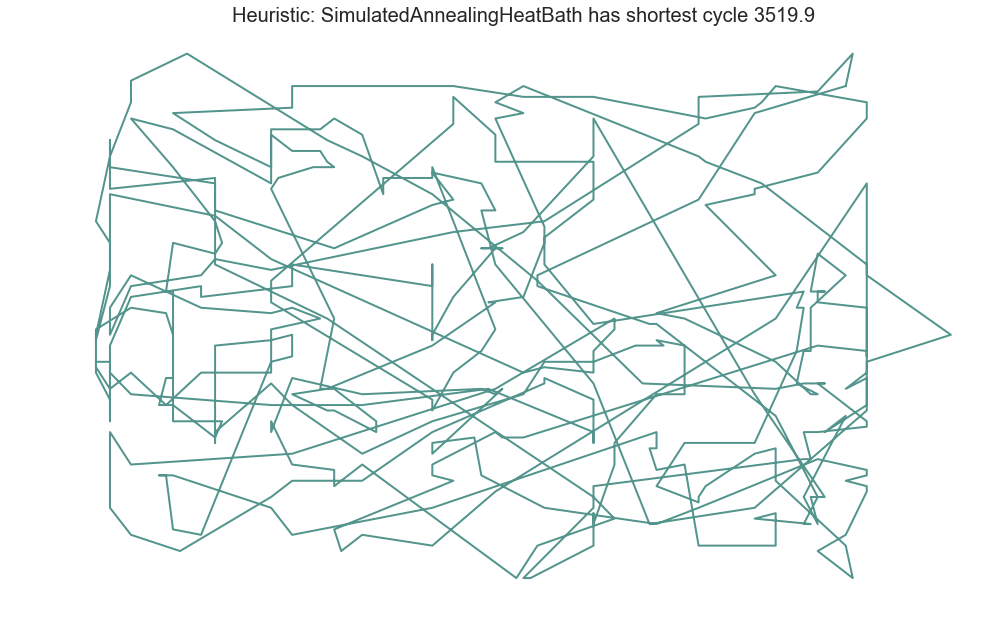

In [19]:
for i, heuristic in enumerate(min_results.index):
    plot_resulting_cycle(heuristic, min_results[i])

### Pairwise Comparison

In [20]:
def build_comparison_plot(results, left_names, right_names, out_name):
    fig = plt.figure()
    length = len(results.index)

    ax1 = fig.add_subplot(111)
    ax1.barh(range(length), width = results.statistic,
             height = 0.4,
            tick_label = left_names)
    ax1.tick_params(axis='both', which='major', labelsize=24,length=0)

    ax2 = ax1.twinx()   # mirror them
    ax2.barh(range(length), width = -results.statistic, height = 0.4, color='white',
            tick_label = right_names)
    ax2.tick_params(axis='both', which='major', labelsize=24,length=0)

    ax1.axes.get_xaxis().set_ticks([])
    ax2.axes.get_xaxis().set_ticks([])

    for spine in ax1.spines.values():
        spine.set_visible(False)
    for spine in ax2.spines.values():
        spine.set_visible(False)

    plt.axvline(linewidth=1, color="black")
    save_fig(out_name)    
    plt.show()


For the two-sample T-test, we assume equal variance in- and idependence between- the two samples.

$H_0$: The sample means are equal.
$H_1$: The sample means are not equal.

The confidence level $\alpha$ is set at 5 %.

A negative statistic indicates that the 'left' sample has a lower mean while a positive statistic indicates that the 'right' sample has a lower mean. When we observe a p-value $\leq \alpha$, we reject the null hypothesis $H_0$ at $\alpha = 5\%$ and thus conclude that the difference in means is significant.

Thus, We can find out which heuristic yields a lower average loss and is thus 'better' at producing short cycles.

#### Construction Heuristics

In [21]:
ttest_b_bb = st.ttest_ind(losses['BestInsertion'], losses['BestBestInsertion'])
ttest_b_se = st.ttest_ind(losses['BestInsertion'], losses['ShortestEdge'])
pairwise_construction = pd.DataFrame({'best-bestbest':
                                      {'statistic': ttest_b_bb.statistic,
                                       'pval': ttest_b_bb.pvalue},
                                      'best-shortest':
                                      {'statistic': ttest_b_se.statistic,
                                       'pval': ttest_b_se.pvalue}}).T

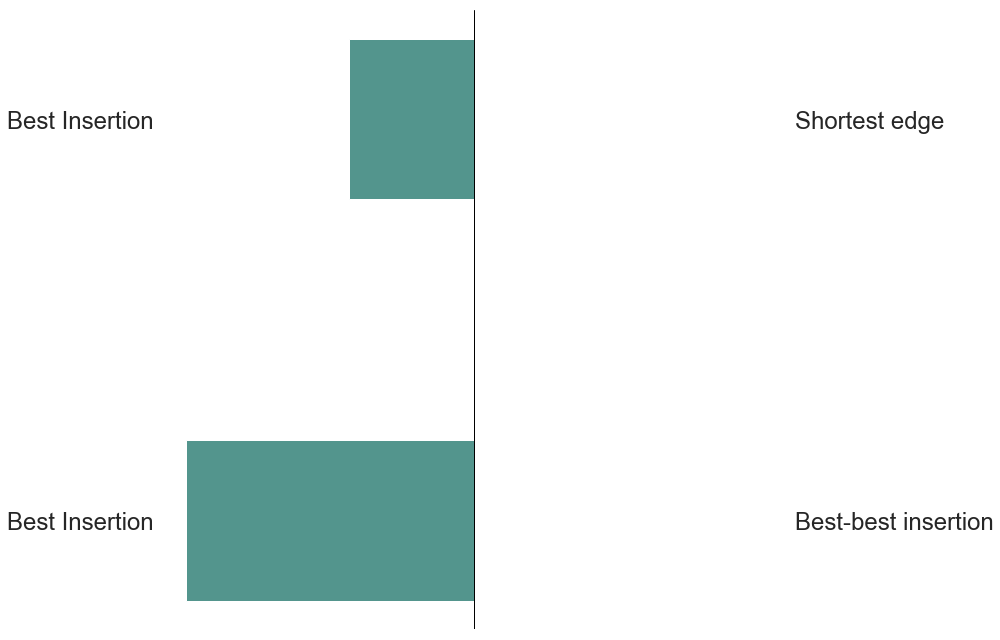

In [22]:
build_comparison_plot(pairwise_construction,
                      ['Best Insertion', 'Best Insertion'],
                      ['Best-best insertion', 'Shortest edge'],
                      "pairwise_construction")

#### Improvement Heuristics

In [23]:
ttest_st = st.ttest_ind(losses['GreedyLocalSearchSwap'], losses['GreedyLocalSearchTranslate'])
ttest_si = st.ttest_ind(losses['GreedyLocalSearchSwap'], losses['GreedyLocalSearchInvert'])
ttest_sm = st.ttest_ind(losses['GreedyLocalSearchSwap'], losses['GreedyLocalSearchMixed'])
ttest_ti = st.ttest_ind(losses['GreedyLocalSearchTranslate'], losses['GreedyLocalSearchInvert'])
ttest_tm = st.ttest_ind(losses['GreedyLocalSearchTranslate'], losses['GreedyLocalSearchMixed'])
ttest_im = st.ttest_ind(losses['GreedyLocalSearchInvert'], losses['GreedyLocalSearchMixed'])
ttest_mh = st.ttest_ind(losses['SimulatedAnnealingMetropolis'], losses['SimulatedAnnealingHeatBath'])

pairwise_improvement = pd.DataFrame({'swap-trans':
                                       {'statistic': ttest_st.statistic,
                                        'pval': ttest_st.pvalue},
                                     'swap-invert':
                                       {'statistic': ttest_si.statistic,
                                        'pval': ttest_si.pvalue},
                                     'swap-mixed':
                                       {'statistic': ttest_sm.statistic,
                                       'pval': ttest_sm.pvalue},
                                     'trans-invert':
                                       {'statistic': ttest_ti.statistic,
                                        'pval': ttest_ti.pvalue},
                                     'trans-mixed':
                                       {'statistic': ttest_tm.statistic,
                                        'pval': ttest_tm.pvalue},
                                     'invert-mixed':
                                       {'statistic': ttest_im.statistic,
                                        'pval': ttest_im.pvalue},
                                     'metro-heat':
                                       {'statistic': ttest_mh.statistic,
                                        'pval': ttest_mh.pvalue}
                                      }).T

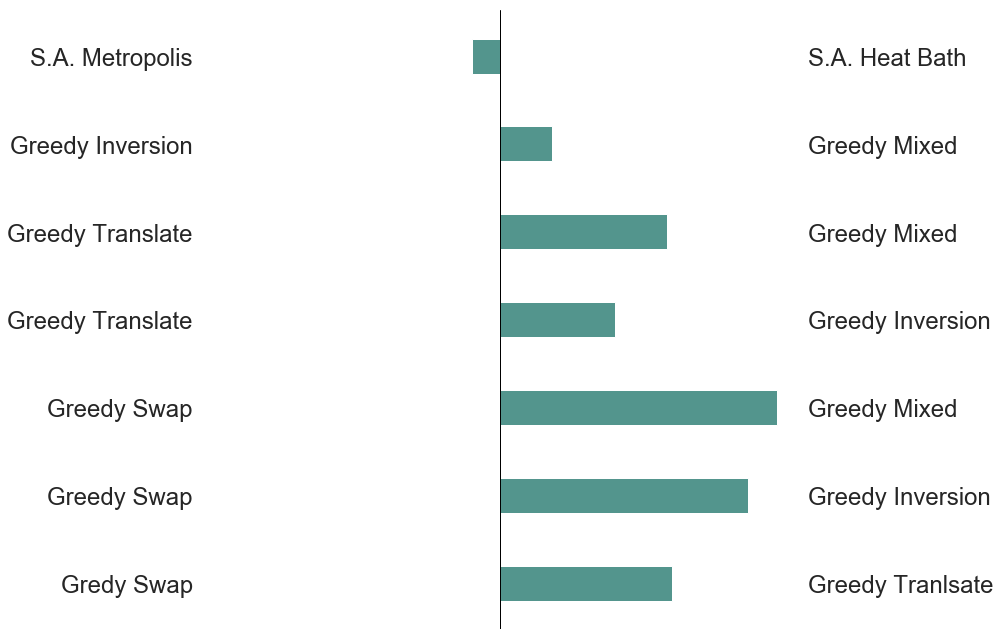

In [24]:
build_comparison_plot(pairwise_improvement,
                      ['Gredy Swap', 'Greedy Swap', 'Greedy Swap', 'Greedy Translate', 'Greedy Translate', 'Greedy Inversion', 'S.A. Metropolis'],
                      ['Greedy Tranlsate', 'Greedy Inversion', 'Greedy Mixed', 'Greedy Inversion', 'Greedy Mixed', 'Greedy Mixed', 'S.A. Heat Bath'],
                      "pairwise_improvement")

### Performance Plots

Performance plots are shown for all improvement heuristics. The loss is high at the beginning when the cycle is initialized at random. It can be expected to decrease to a lower value as more and more improvements are made. Convergence is indicated by a constant slope of the curve. The point where this leveling occurs can be interpreted as the minimum number of iterations necessary to arrive at a 'good' solution.

In [25]:
performance_file = Path('./performance.pkl')
if performance_file.is_file():
    with open(performance_file, 'rb') as input:
        performance = pickle.load(input)
else:
    performance = {}
    heuristics = [
                th.GreedyLocalSearchSwap(tsp),
                th.GreedyLocalSearchTranslate(tsp),
                th.GreedyLocalSearchInvert(tsp),
                th.GreedyLocalSearchMixed(tsp),
                th.SimulatedAnnealingMetropolis(tsp),
                th.SimulatedAnnealingHeatBath(tsp)
            ]
    for h in heuristics:
        h.calculate_cycle(save_steps=True)
        log("Iteration {}: {} done".format(i+1, h.__class__.__name__))
        performance[h.__class__.__name__] = h.steps
        with open("./performance.pkl", "wb") as output:
            pickle.dump(performance)

In [26]:
gls_performance = pd.DataFrame({'Swap': performance['GreedyLocalSearchSwap'],
                                'Translation': performance['GreedyLocalSearchTranslate'],
                                'Inversion': performance['GreedyLocalSearchInvert'],
                                'Mixed': performance['GreedyLocalSearchMixed']})

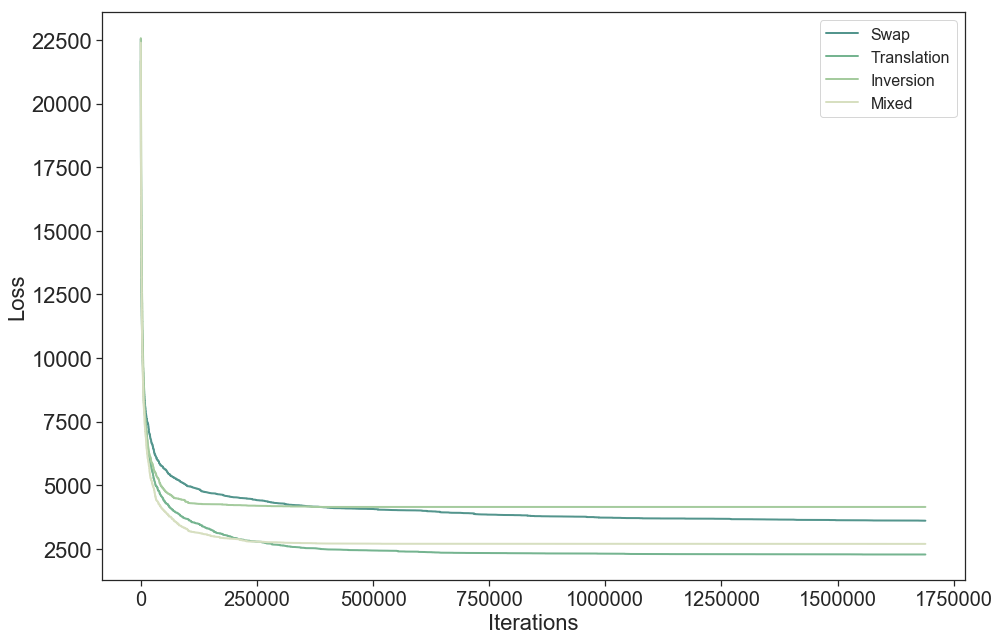

In [27]:
plt.plot(gls_performance)
plt.legend(labels=['Swap','Translation', 'Inversion', 'Mixed'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
save_fig("greedy_local_search_performance")
plt.show()

In [28]:
met_performance = pd.DataFrame(performance['SimulatedAnnealingMetropolis']).T

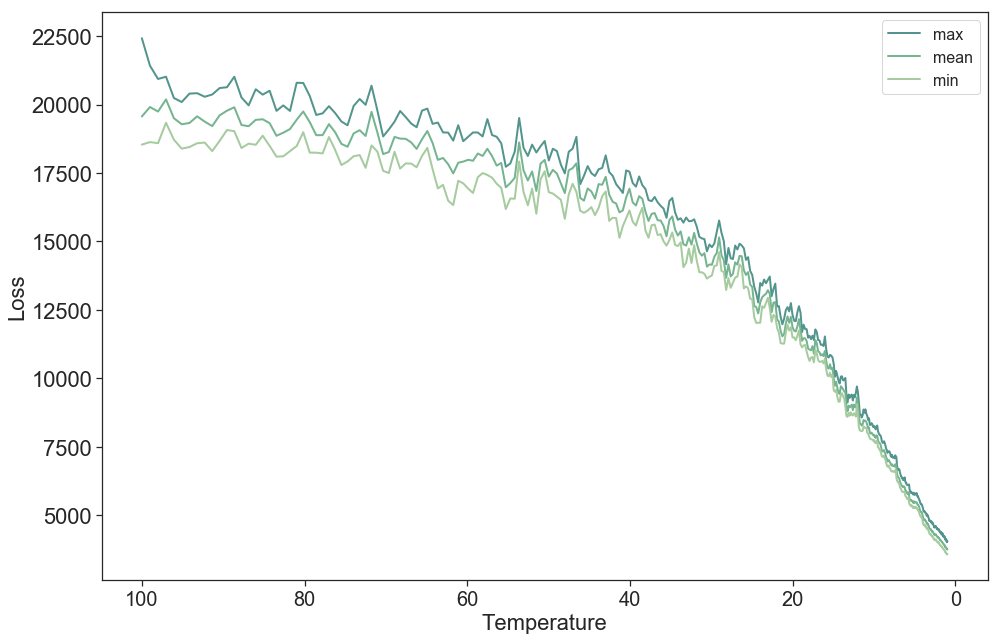

In [29]:
plt.plot(met_performance)
plt.legend(labels=['max', 'mean', 'min'])
plt.gca().invert_xaxis()
plt.xlabel('Temperature')
plt.ylabel('Loss')
save_fig("simulated_annealing_metro_performance")
plt.show()

In [30]:
hb_performance = pd.DataFrame(performance['SimulatedAnnealingHeatBath']).T

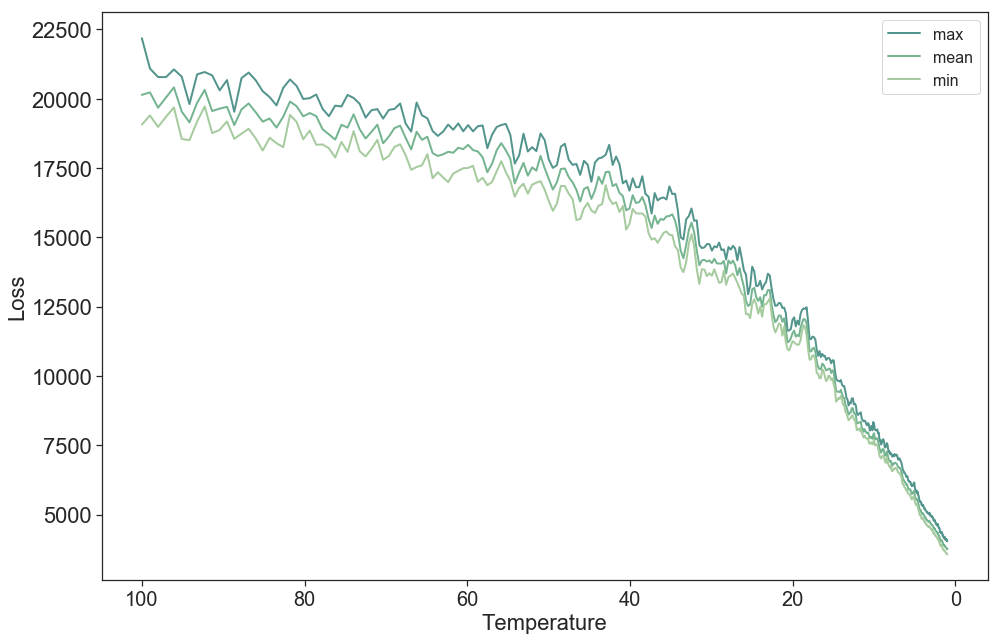

In [31]:
plt.plot(hb_performance)
plt.legend(labels=['max', 'mean', 'min'])
plt.gca().invert_xaxis()
plt.xlabel('Temperature')
plt.ylabel('Loss')
save_fig("simulated_annealing_heatbath_performance")
plt.show()